# 평균모멘텀스코어 현금 혼합 그림 2-26
- 투자 기간 :1986년 1월~2017년 6월
- 투자 대상 : 코스피200지수(코스피200지수 추종 ETF), 현금(3년 만기 국고채=> 이론현금)
- 매수 규칙 : 
  -  주식 : 현금 투자비율 = 주식 1~12개월 평균 모멘텀 스코어:1(현금 평균 모멘텀 비중)
- 매도 규칙 : 매달 말 위의 투자 비중을 새로 계산하여 주식 :현금 투자 비중을 조절하여 반복
- 문제점 : 횡보장(2011.6~2016)
- 10.83%/-33.1%

In [1]:
from settings import *

In [2]:
# 직접생성
# kospi = fdr.DataReader("KS11")['Close']
# df = pd.DataFrame()
# df['KOSPI'] = kospi.copy()
# df = df['1985-1':'2017-6'].resample('MS').first() # 실제 말 마지막날이 공휴일이어도 마지막날 거래 한것과 같이 된다.
# df['현금'] = pow(1.03, 1/12)
# df['현금'] = df['현금'].shift(1, fill_value=1.0)
# df['현금'] = df['현금'].cumprod()
# df

In [3]:
df = pd.read_csv('kospi_m.csv', index_col=0, parse_dates=True)
#-------------------------------------------
df['현금'] = pow(1.03, 1/12)
df['현금'] = df['현금'].shift(1, fill_value=1.0)
df['현금'] = df['현금'].cumprod()
#-------------------------------------------
df.head()

,KOSPI,현금
날짜,,
1985-01-04,1.000,1.000
1985-02-01,0.970,1.002
1985-03-02,0.982,1.005
1985-04-01,0.966,1.007
1985-05-01,0.965,1.010


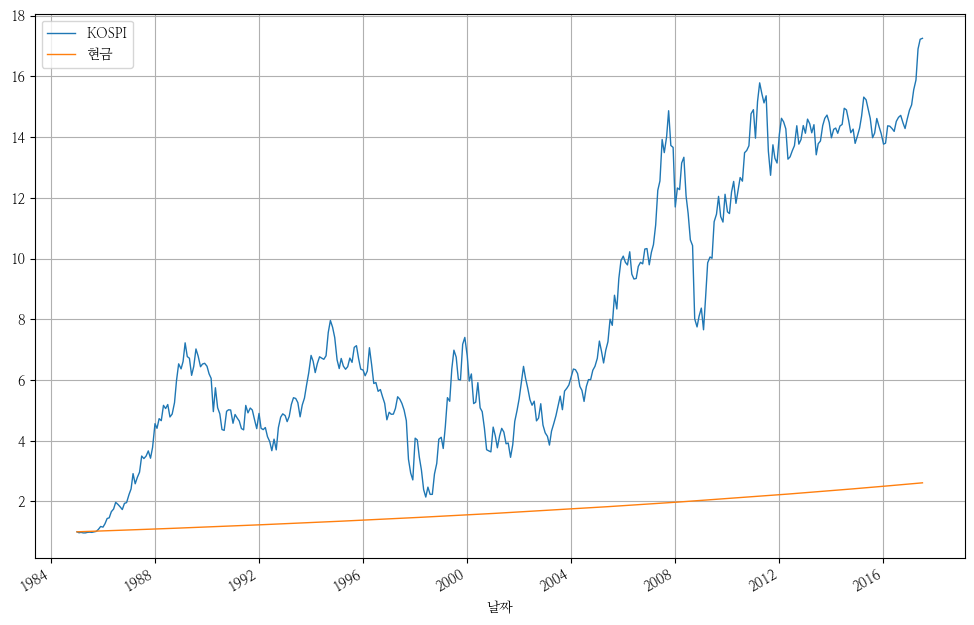

In [4]:
df.rebase(1).plot(figsize=(12,8));

In [5]:
data = df[:'2017-06'].copy()

In [6]:
bt_ew = long_only_ew(data, ['KOSPI', '현금'], "ew")

In [7]:
def 평균모멘텀(데이터):
    초기값 = 0
    for i in range(1, 13):
        초기값 = 데이터 / 데이터.shift(i) + 초기값
    return 초기값 / 12

def 모멘텀순위(데이터, 순위):
    x = 평균모멘텀(데이터)
    y = x.iloc[ : , 0: len(x.columns)].rank(1, ascending=0)
    y[y <= 순위] = 1
    y[y > 순위] = 0
    return y

def 평균모멘텀스코어(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 13):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/12
    return a

In [8]:
score = 평균모멘텀스코어(data)

In [9]:
# KOSPI만 평균모멘텀스코어 비중 만큼 투자하고 나머지는 현금
weights0 = pd.DataFrame()
weights0['KOSPI'] = score['KOSPI']
weights0['현금']  = 1.0 - score['KOSPI']
weights0.head(20) # 1986-1 이후 유효

,KOSPI,현금
날짜,,
1985-01-04,NaN,NaN
1985-02-01,NaN,NaN
1985-03-02,NaN,NaN
1985-04-01,NaN,NaN
1985-05-01,NaN,NaN
1985-06-01,NaN,NaN
1985-07-01,NaN,NaN
1985-08-01,NaN,NaN
1985-09-02,NaN,NaN


In [10]:
# 현금도 하나의 자산으로 취급. 이론 현금은 항상 모멘텀스코어가 1이다.
# 따라서 주식 비중이 0.5를 넘을 수 없다.
weights = score.copy()
weights = weights.div(weights.sum(axis=1), axis=0) # !!
weights.head(20)

,KOSPI,현금
날짜,,
1985-01-04,NaN,NaN
1985-02-01,NaN,NaN
1985-03-02,NaN,NaN
1985-04-01,NaN,NaN
1985-05-01,NaN,NaN
1985-06-01,NaN,NaN
1985-07-01,NaN,NaN
1985-08-01,NaN,NaN
1985-09-02,NaN,NaN


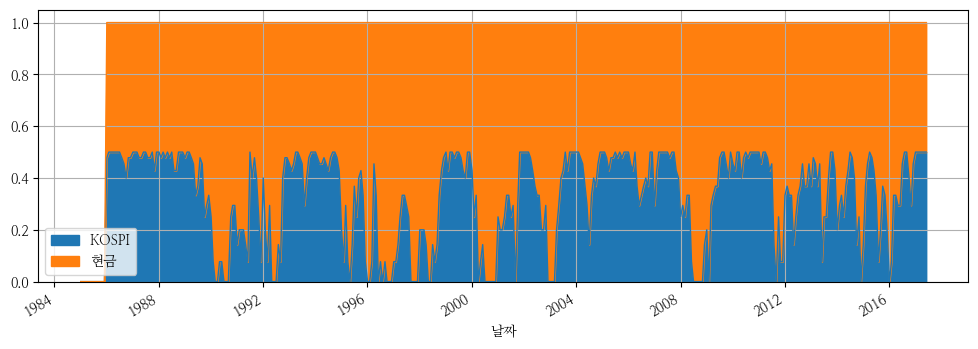

In [11]:
weights.plot.area(figsize=(12,4));

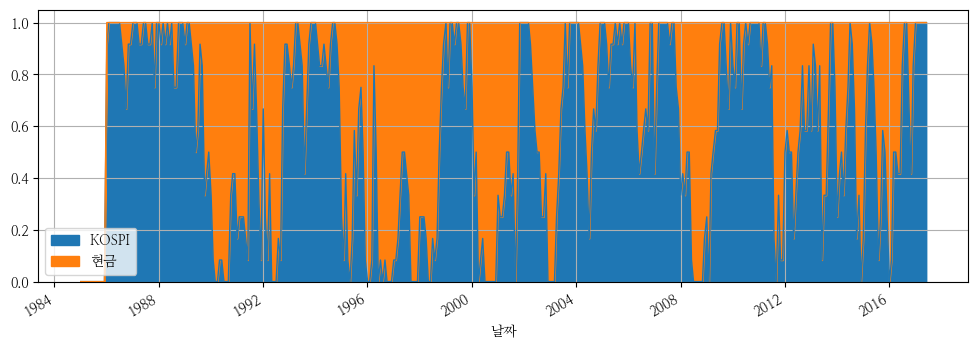

In [12]:
weights0.plot.area(figsize=(12,4));

In [17]:
def momentumscore(data, weights, name="MomScore", start='1986-1-03'):
    st = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_last_date=True),
            bt.algos.RunAfterDate(start), #1년 뒤부터 시작 : 시작전 12개월 데이터 필요
            bt.algos.SelectAll(),
            bt.algos.WeighTarget(weights),
#             bt.algos.PrintInfo("{now} {temp}"), #{_price} {_universe} 
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000.0)

In [18]:
# shift(1)을 하면 전달 기준으로 모멘텀 계산
bt_ms0 = momentumscore(data, weights0.dropna(), name='모멘텀 포트폴리오(KOSPI)')#.shift(1))
bt_ms = momentumscore(data, weights.dropna(), name='모멘텀 포트폴리오(현금혼합)')#.shift(1))


In [19]:
bt_kospi = long_only_ew(data, ['KOSPI'], 'KOSPI')
bt_현금 = long_only_ew(data, ['현금'], '현금')

In [20]:
r_ms = bt.run(bt_ms)#, bt_kospi, bt_ew)

In [21]:
r_ms.set_date_range('1986-1-4')
r_ms.display()

Stat                 모멘텀 포트폴리오(현금혼합)
-------------------  -----------------------------
Start                1986-01-04
End                  2017-06-01
Risk-free rate       0.00%

Total Return         808.96%
Daily Sharpe         -
Daily Sortino        -
CAGR                 7.28%
Max Drawdown         -19.12%
Calmar Ratio         0.38

MTD                  1.07%
3m                   7.53%
6m                   9.43%
YTD                  9.43%
1Y                   11.05%
3Y (ann.)            3.96%
5Y (ann.)            3.00%
10Y (ann.)           3.66%
Since Incep. (ann.)  7.28%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    -
Daily Vol (ann.)     -
Daily Skew           -
Daily Kurt           -
Best Day             -
Worst Day            -

Monthly Sharpe       0.82
Monthly Sortino      1.84
Monthly Mean (ann.)  7.45%
Monthly Vol (ann.)   9.14%
Monthly Skew         0.92
Monthly Kurt         2.25
Best Month           10.92%
Worst Month          -5.62%

Yearly Sharpe    

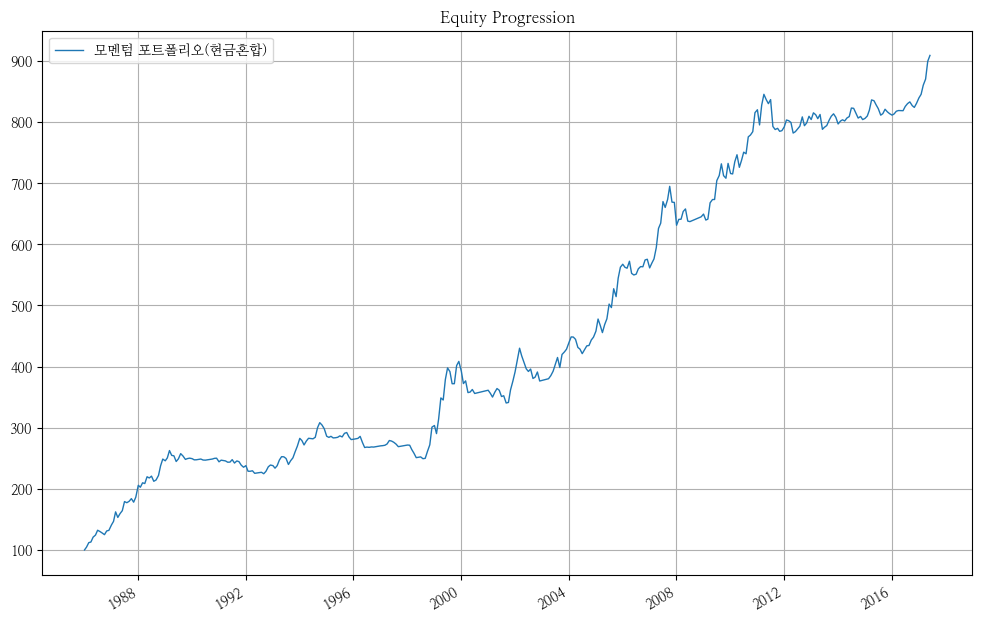

In [22]:
r_ms.plot(figsize=(12,8));

In [23]:
r_all = bt.run(bt_ms, bt_ms0, bt_kospi, bt_ew)

1985-01-04 00:00:00
1985-01-04 00:00:00


In [25]:
r_all.set_date_range('1986-1-4')
r_all.display()

Stat                 모멘텀 포트폴리오(현금혼합)    모멘텀 포트폴리오(KOSPI)    KOSPI       ew
-------------------  -----------------------------  --------------------------  ----------  ----------
Start                1986-01-04                     1986-01-04                  1986-01-04  1986-01-04
End                  2017-06-01                     2017-06-01                  2017-06-01  2017-06-01
Risk-free rate       0.00%                          0.00%                       0.00%       0.00%

Total Return         808.96%                        2462.73%                    1390.95%    807.42%
Daily Sharpe         -                              -                           -           -
Daily Sortino        -                              -                           -           -
CAGR                 7.28%                          10.88%                      8.98%       7.27%
Max Drawdown         -19.12%                        -33.07%                     -73.06%     -60.93%
Calmar Ratio         0.38      

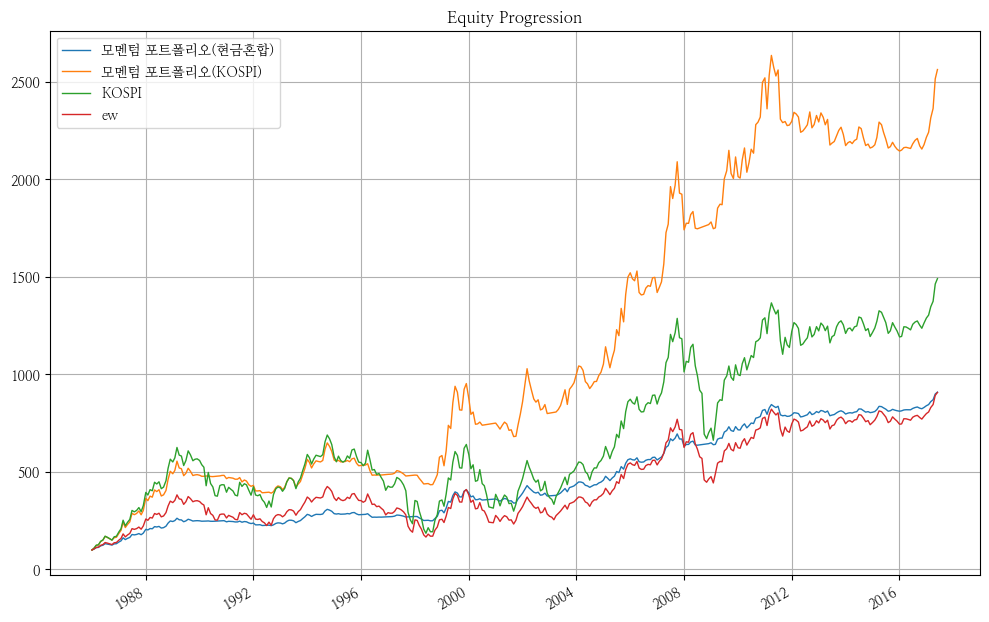

In [27]:
r_all.plot(figsize=(12,8));

In [28]:
r_현금 = bt.run(bt_현금)
r_kospi = bt.run(bt_kospi)
r_ms0 = bt.run(bt_ms0)

1985-01-04 00:00:00


# 그림 2.26

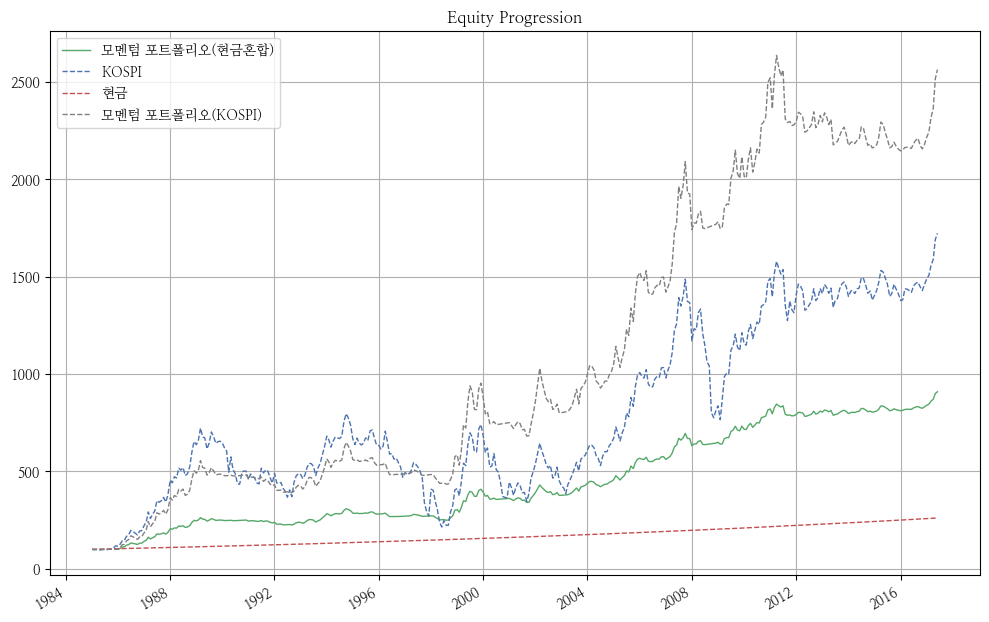

In [29]:
ax1 = r_ms.plot(color='g', figsize=(12,8));
r_kospi.plot(ax=ax1, ls='--', color='b', figsize=(12, 8));
r_현금.plot(ax=ax1, ls='--', color='r', figsize=(12, 8));
#----
r_ms0.plot(ax=ax1, ls='--', color='gray', figsize=(12, 8));

In [30]:
# qs.reports.full(r_all.prices['모멘텀 포트폴리오(현금혼합)'].to_returns().dropna()['1986':],
#                 r_all.prices['KOSPI'].to_returns().dropna()['1986':])


# 일일데이터

In [31]:
kospi = fdr.DataReader("KS11")['Close']
data_daily = pd.DataFrame()
data_daily['KOSPI'] = kospi.copy()
data_daily = data_daily['1985-1':'2020-9']
# %%
dd = pd.DataFrame()
# dd.index = pd.date_range('1985', '2020-9-30', freq='D')
dd.index = pd.date_range('1985', '2020-12-31', freq='D')
denominator = len(pd.date_range('1985', '2020-12-31', freq='D'))/len(pd.date_range('1985', '2020-12-31', freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily = pd.merge(data_daily, dd, left_index=True, right_index=True, how='left')

In [32]:
data_daily

,KOSPI,현금
Date,,
1985-01-04,139.530,1.000
1985-01-05,141.790,1.000
1985-01-07,145.510,1.000
1985-01-08,145.390,1.001
1985-01-09,143.260,1.001
...,...,...
2020-09-23,2333.240,2.875
2020-09-24,2272.700,2.875
2020-09-25,2278.790,2.875


In [33]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMSWithCash(bt.Algo):
    def __init__(self, lags, months, cash):
        super(WeighAMSWithCash, self).__init__()
        self.lags = lags
        self.months = months
        self.cash = cash

    def 평균모멘텀스코어(self, 데이터, 개월):
        초기값 = 0
        for i in range(1, 개월+1):
            초기값 += np.where(데이터 / 데이터.shift(i) > 1, 1, 0)
        return 초기값[-1]/개월

    def AMS(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        average_momentum_score = pd.Series(dtype='float64')
        # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = (target.now - pd.DateOffset(months=self.lags)).strftime("%Y-%m")
        start = (target.now - pd.DateOffset(months=self.lags) - pd.DateOffset(months=self.months)).strftime("%Y-%m")

        # t0 = (target.now).strftime("%Y-%m")
        # start = (target.now -  pd.DateOffset(years=1)).strftime("%Y-%m")

        # print(selected, t0)
#         print(f"\nprc : {target.now} {t0} ~ {start}")
        prc = target.universe[selected].loc[start:t0].resample('M').last()
        if (len(prc) < self.months+1):
            return False

        # weights = pd.Series(self.평균모멘텀스코어(prc, self.months), index=selected)
        weights = pd.Series(self.AMS(prc), index=selected)
        weights = weights/weights.sum()
        
        # print(self.평균모멘텀스코어(prc, self.months), prc)
        target.temp['weights'] = weights
#         print(f"{target.now} ", end =" ")
#         for i, v in weights.items():
#             print(f"{i}:{v:.3f}", end=" ")
#         print("")
        return True

In [35]:
#%%
def momentum_mixedcash(name, data, lags=0, months=12, cash='현금'):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=False,
                                run_on_last_date=False),
            # bt.algos.PrintInfo('{name} : {now}'),
            bt.algos.SelectThese(['KOSPI', '현금']),
            WeighAMSWithCash(lags=lags, months=months, cash=cash),
            # bt.algos.PrintTempData(),
            bt.algos.Rebalance()
        ]
    )
    test = bt.Backtest(st, data, initial_capital=100000000)
    return test

In [37]:
bt_cash = momentum_mixedcash("모멘텀(현금혼합)", data)
r_cash = bt.run(bt_2, bt_ms)

In [38]:
# 처음과 동일함을 검증(로직)
r_cash.set_date_range('1986-1-4')
r_cash.display()

Stat                 모멘텀(현금혼합)    모멘텀 포트폴리오(현금혼합)
-------------------  ------------------  -----------------------------
Start                1986-01-04          1986-01-04
End                  2017-06-01          2017-06-01
Risk-free rate       0.00%               0.00%

Total Return         808.96%             808.96%
Daily Sharpe         -                   -
Daily Sortino        -                   -
CAGR                 7.28%               7.28%
Max Drawdown         -19.12%             -19.12%
Calmar Ratio         0.38                0.38

MTD                  1.07%               1.07%
3m                   7.53%               7.53%
6m                   9.43%               9.43%
YTD                  9.43%               9.43%
1Y                   11.05%              11.05%
3Y (ann.)            3.96%               3.96%
5Y (ann.)            3.00%               3.00%
10Y (ann.)           3.66%               3.66%
Since Incep. (ann.)  7.28%               7.28%

Daily Sharpe         -  

In [39]:
bt_daily = momentum_mixedcash("모멘텀(현금혼합,일간)", data_daily)

In [40]:
r_daily = bt.run(bt_daily)

In [41]:
r_daily.set_date_range('1986-1-4', '2017-06-01')
r_daily.display()

Stat                 모멘텀(현금혼합,일간)
-------------------  -----------------------
Start                1986-01-04
End                  2017-06-01
Risk-free rate       0.00%

Total Return         809.40%
Daily Sharpe         0.85
Daily Sortino        1.39
CAGR                 7.28%
Max Drawdown         -19.57%
Calmar Ratio         0.37

MTD                  -0.06%
3m                   6.33%
6m                   9.06%
YTD                  8.12%
1Y                   9.79%
3Y (ann.)            3.64%
5Y (ann.)            2.77%
10Y (ann.)           3.42%
Since Incep. (ann.)  7.28%

Daily Sharpe         0.85
Daily Sortino        1.39
Daily Mean (ann.)    6.99%
Daily Vol (ann.)     8.18%
Daily Skew           -0.07
Daily Kurt           5.98
Best Day             3.67%
Worst Day            -3.77%

Monthly Sharpe       0.81
Monthly Sortino      1.87
Monthly Mean (ann.)  7.47%
Monthly Vol (ann.)   9.22%
Monthly Skew         0.91
Monthly Kurt         1.99
Best Month           10.76%
Worst Month        

In [42]:
r_daily.prices['1986-1-4':].to_drawdown_series().describe()

,"모멘텀(현금혼합,일간)"
count,8360.000
mean,-0.062
std,0.046
min,-0.196
25%,-0.087
50%,-0.058
75%,-0.025
max,0.000
